In [268]:
import geopandas as gpd
from sodapy import Socrata
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.dates as mdates


from hidden_config import Config

Use API key and credentials to query Socrata database

In [376]:
url = "data.cityofchicago.org"
client = Socrata(url,
                 Config.API_KEY,
                 username=Config.USERNAME,
                 password=Config.PASSWORD)

red_light_violations_uri = 'spqx-js37'
speed_camera_violations_uri = 'hhkd-xvj4'

red_light_violations_list = client.get(red_light_violations_uri, limit=10000)
speed_camera_violations_list = client.get(speed_camera_violations_uri, limit=10000)

red_light_violations_df = pd.DataFrame(red_light_violations_list)
speed_camera_violations_df = pd.DataFrame(speed_camera_violations_list)


### Data Cleansing
Cast the columns to their proper data types

In [379]:
speed_camera_violations_df['violations'] = speed_camera_violations_df['violations'].astype(float)
red_light_violations_df['violations'] = red_light_violations_df['violations'].astype(float)

speed_camera_violations_df['violation_date'] = pd.to_datetime(speed_camera_violations_df['violation_date'])
red_light_violations_df['violation_date'] = pd.to_datetime(red_light_violations_df['violation_date'])

speed_camera_violations_df['violation_day_of_week'] = speed_camera_violations_df['violation_date'].dt.strftime('%A')
red_light_violations_df['violation_day_of_week'] = pd.to_datetime(red_light_violations_df['violation_date']).dt.strftime('%A')


### Data Summary


In [440]:
print(f"There are {speed_camera_violations_df['camera_id'].nunique()} speed cameras in the city. They issue {round(speed_camera_violations_df.groupby('violation_date')['violations'].mean().mean(),1)} tickets per day")
print(f"There are {red_light_violations_df['camera_id'].nunique()} red light cameras in the city. They issue {round(red_light_violations_df.groupby('violation_date')['violations'].mean().mean(),1)} tickets per day")

There are 160 speed cameras in the city. They issue 52.0 tickets per day
There are 296 red light cameras in the city. They issue 6.5 tickets per day


Consider the distribution of how many cameras are issuing tickets

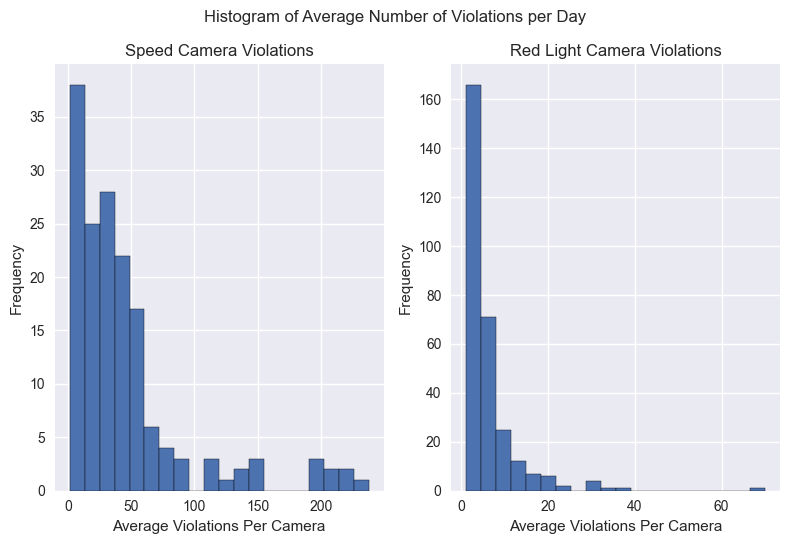

In [540]:
plt.style.use('seaborn-v0_8')
fig, ax = plt.subplots(1, 2)

average_speed_violations_per_camera_per_day = speed_camera_violations_df.groupby(['camera_id', 'violation_date'])['violations'].sum().groupby('camera_id').mean()
average_red_light_violations_per_camera_per_day = red_light_violations_df.groupby(['camera_id', 'violation_date'])['violations'].sum().groupby('camera_id').mean()

ax[0].hist(average_speed_violations_per_camera_per_day, bins=20, edgecolor='black')
ax[1].hist(average_red_light_violations_per_camera_per_day, bins=20, edgecolor='black')

ax[0].set_xlabel('Average Violations Per Camera')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Speed Camera Violations')

ax[1].set_xlabel('Average Violations Per Camera')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Red Light Camera Violations')

fig.suptitle('Histogram of Average Number of Violations per Day')
plt.tight_layout()
plt.show()

In [586]:
camera_id_of_highest_frequency = red_light_violations_df.groupby(['camera_id', 'violation_date'])['violations'].sum().groupby('camera_id').mean().sort_values().index[-1]
highest_average_frequency = red_light_violations_df.groupby(['camera_id', 'violation_date'])['violations'].sum().groupby('camera_id').mean().sort_values().values[-1]
intersection_of_highest_red_light_violations = red_light_violations_df[red_light_violations_df['camera_id'] == camera_id_of_highest_frequency]['intersection'].unique()[0]

print(f"We can see there is an outlier for the red light camera violations. \
      \nOne camera is averaging {highest_average_frequency} violations per day even though the average for the rest of the dataset is {round(red_light_violations_df.groupby('violation_date')['violations'].mean().mean(),1)} violations per day. \
      \nThis intersection is {intersection_of_highest_red_light_violations}")

We can see there is an outlier for the red light camera violations.       
One camera is averaging 70.0 violations per day even though the average for the rest of the dataset is 6.5 violations per day.       
This intersection is LAKE SHORE DR AND BELMONT


Sure enough, we can see this fastidious fine facilitator [here](https://www.google.com/maps/@41.9404408,-87.6389125,3a,85.9y,337.73h,89.01t/data=!3m6!1e1!3m4!1s45oLMBFgk2CaYhTA8ty-RQ!2e0!7i16384!8i8192?entry=ttu)

### Temporal Analysis
Let's see how the number of violations trends over time.

They add more cameras over time, so we need to calculate how many new cameras there have been.

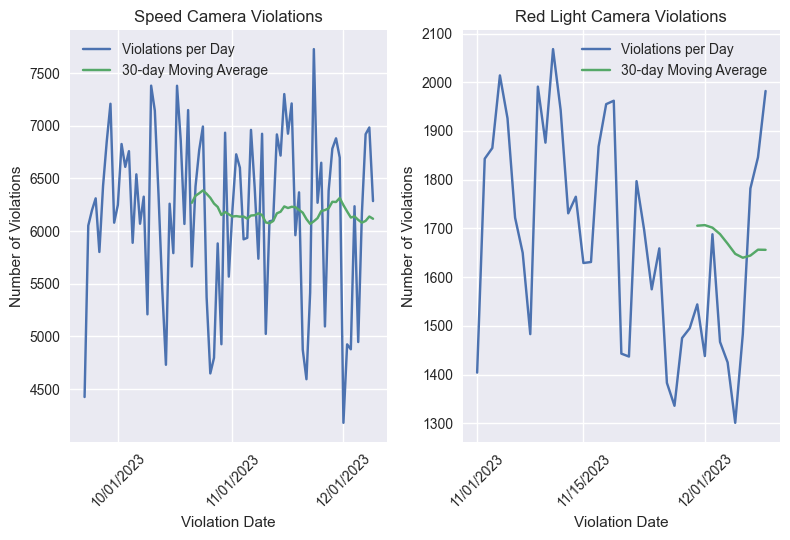

In [383]:
speed_camera_violations_df['30_day_ma'] = speed_camera_violations_df['violations'].rolling(window=30).mean()

plt.style.use('seaborn-v0_8')
fig, ax = plt.subplots(1, 2)

ax[0].plot(speed_camera_violations_df.groupby('violation_date')['violations'].sum(), label='Violations per Day')

speed_camera_daily_sum = pd.DataFrame(speed_camera_violations_df.groupby('violation_date')['violations'].sum())
speed_camera_ma = speed_camera_daily_sum.rolling(window=30).mean()
ax[0].plot(speed_camera_ma['violations'], label='30-day Moving Average')


ax[0].tick_params(axis='x', rotation=45)
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
ax[0].set_xticks(ax[0].get_xticks()[::2])
ax[0].set_xlabel('Violation Date')
ax[0].set_ylabel('Number of Violations')
ax[0].set_title('Speed Camera Violations')
ax[0].legend()

ax[1].plot(red_light_violations_df.groupby('violation_date')['violations'].sum(), label='Violations per Day')

red_light_daily_sum = pd.DataFrame(red_light_violations_df.groupby('violation_date')['violations'].sum())
red_light_ma = red_light_daily_sum.rolling(window=30).mean()
ax[1].plot(red_light_ma['violations'], label='30-day Moving Average')


ax[1].tick_params(axis='x', rotation=45)
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
ax[1].set_xticks(ax[1].get_xticks()[::2])
ax[1].set_xlabel('Violation Date')
ax[1].set_ylabel('Number of Violations')
ax[1].set_title('Red Light Camera Violations')
ax[1].legend()
plt.tight_layout()
plt.show()



DoW Analysis

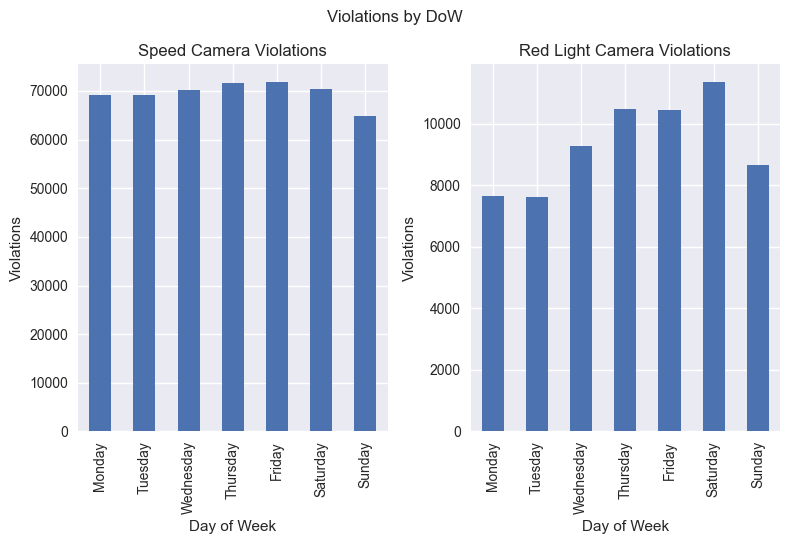

In [381]:
# Sum violations by day of week
speed_camera_violations_by_dow = speed_camera_violations_df.groupby(['violation_day_of_week'])['violations'].sum()

# Do the same for red light cameras
red_light_violations_by_dow = red_light_violations_df.groupby(['violation_day_of_week'])['violations'].sum()

# Create a Categorical data type with the desired order
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
cat_order = pd.CategoricalDtype(categories=day_order, ordered=True)

speed_camera_violations_by_dow.index = speed_camera_violations_by_dow.index.astype(cat_order)
red_light_violations_by_dow.index = red_light_violations_by_dow.index.astype(cat_order)

plt.style.use('seaborn-v0_8')
fig, ax = plt.subplots(1, 2)

speed_camera_violations_by_dow.sort_index().plot(kind='bar', ax=ax[0])
red_light_violations_by_dow.sort_index().plot(kind='bar', ax=ax[1])

ax[0].set_xlabel('Day of Week')
ax[0].set_ylabel('Violations')
ax[0].set_title('Speed Camera Violations')

ax[1].set_xlabel('Day of Week')
ax[1].set_ylabel('Violations')
ax[1].set_title('Red Light Camera Violations')

fig.suptitle('Violations by DoW')
plt.tight_layout()
plt.show()


In [31]:
# Read the GeoJSON data from the boundaries shapefiles. 
chicago_communities = gpd.read_file('chicago_communities')

In [77]:
# Extract the latitude and longitude values from the 'location' column
red_light_violations_df['latitude'] = red_light_violations_df['location'].apply(lambda x: x['latitude'] if isinstance(x, dict) and 'latitude' in x else None)
red_light_violations_df['longitude'] = red_light_violations_df['location'].apply(lambda x: x['longitude'] if isinstance(x, dict) and 'longitude' in x else None)



In [384]:
red_light_violations_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   intersection                 10000 non-null  object        
 1   camera_id                    10000 non-null  object        
 2   address                      10000 non-null  object        
 3   violation_date               10000 non-null  datetime64[ns]
 4   violations                   10000 non-null  float64       
 5   x_coordinate                 9467 non-null   object        
 6   y_coordinate                 9467 non-null   object        
 7   latitude                     9467 non-null   object        
 8   longitude                    9467 non-null   object        
 9   location                     9467 non-null   object        
 10  :@computed_region_awaf_s7ux  9467 non-null   object        
 11  :@computed_region_6mkv_f3dw  9467 non-null